# Chest X-ray Image Classification 


In [1]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision import datasets
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline

## Exploring the Data

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal). <br>

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

### Acknowledgements
Data: https://data.mendeley.com/datasets/rscbjbr9sj/2 <br>
License: CC BY 4.0<br>
Citation: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5 

In [2]:
DATA_DIR = '../input/chest-xray-pneumonia/chest_xray/chest_xray/'
TRAIN_DIR = DATA_DIR + '/train'
VALID_DIR = DATA_DIR + '/test'                            

In [3]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

train_transforms = transforms.Compose([transforms.Resize((224,224),interpolation=Image.NEAREST),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(*stats,inplace=True)
                                   ])
test_transforms = transforms.Compose([transforms.Resize((224,224),interpolation=Image.NEAREST),
                                      transforms.ToTensor(),
                                      transforms.Normalize(*stats)
                                  ])

In [4]:
dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
test_data = datasets.ImageFolder(VALID_DIR, transform=test_transforms)

In [5]:
print(dataset.classes)
print(len(dataset))

['NORMAL', 'PNEUMONIA']
5216


-----------
# Train and Validation Datasets

In [6]:
random_seed = 42
torch.manual_seed(random_seed);

In [7]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

In [8]:
train_data, valid_data = random_split(dataset, [train_size, val_size])
len(train_data), len(valid_data)

(4695, 521)

In [9]:
BATCH_SIZE = 64

In [10]:
train_dl = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True,num_workers=2,pin_memory=True)
valid_dl = DataLoader(valid_data,batch_size=BATCH_SIZE*2,num_workers=2,pin_memory=True)
test_dl = DataLoader(test_data,batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

-----------
# Preview some images

In [11]:
def decode_label(label_number):
    if label_number==0:
        return "NORMAL"
    return "PNEUMONIA"

In [12]:
def show_image(img_tuple):
    plt.imshow(img_tuple[0].permute(1,2,0))
    print("Label: ",decode_label(img_tuple[1]))

Label:  NORMAL


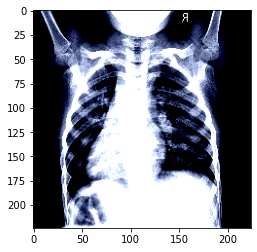

In [13]:
show_image(dataset[0])

In [14]:
def show_batch(dl, invert=False):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

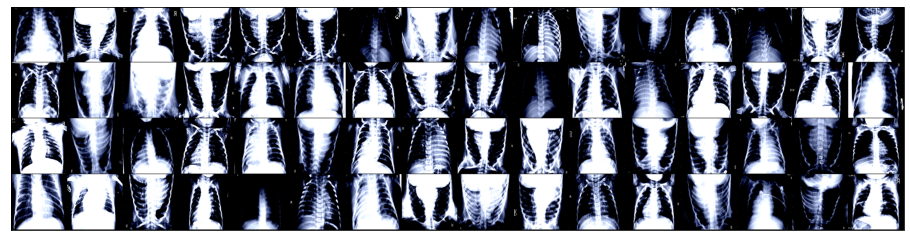

In [15]:
show_batch(train_dl)

---------------------------------------------
# Model

In [16]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [17]:
device = get_default_device()
device

device(type='cuda')

In [18]:
def accuracy(outputs, labels):
    preds = [1 if pred>0.5 else 0 for pred in outputs]
    preds = torch.as_tensor(preds, dtype=torch.float32, device=device)
    preds = preds.view([torch.tensor(preds.shape).item(), 1])
    acc = torch.tensor(torch.sum(preds == labels).item() / len(preds), device=device)
    return acc

In [19]:
class BinaryClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        targets = torch.tensor(targets.clone().detach(), dtype=torch.float32, device=device)
        targets = targets.view([torch.tensor(targets.shape).item(),1])
        out = self(images)
        loss = F.binary_cross_entropy(out, targets) 
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        targets = torch.tensor(targets.clone().detach(), dtype=torch.float32, device=device)
        targets = targets.view([torch.tensor(targets.shape).item(),1]) 
        out = self(images)
        loss = F.binary_cross_entropy(out, targets)
        acc = accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_acc': acc }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_scores = [x['val_acc'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [20]:
class PneumoniaCnnModel(BinaryClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.resnet50(pretrained=True)
        n_features = self.network.fc.in_features
        self.network.fc = nn.Linear(n_features, 1)
    
    def forward(self, xb):        
        return torch.sigmoid(self.network(xb))

In [21]:
trn_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(valid_dl, device)
tst_dl = DeviceDataLoader(test_dl, device)

In [22]:
model = to_device(PneumoniaCnnModel(), device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [23]:
def try_batch(dl):
    for images, labels in dl:
        print('images.shape:', images.shape)
        out = model(images)
        print('out.shape:', out.shape)
        print('out[0]:', out[0])
        break

try_batch(trn_dl)

images.shape: torch.Size([64, 3, 224, 224])
out.shape: torch.Size([64, 1])
out[0]: tensor([0.3803], device='cuda:0', grad_fn=<SelectBackward>)


-----------------------------------------
# Training the model

In [24]:
from tqdm.notebook import tqdm

In [25]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            sched.step()
        
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [29]:
history = [evaluate(model, val_dl)]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


In [30]:
num_epochs = 20
max_lr = 1e-2
opt_func = torch.optim.Adam
grad_clip = 0.1
weight_decay = 1e-4

In [31]:
history += fit(num_epochs, max_lr, model, trn_dl, val_dl, weight_decay=weight_decay, grad_clip=grad_clip, opt_func=opt_func)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


Epoch [0], train_loss: 0.1021, val_loss: 0.2385, val_acc: 0.9434



Epoch [1], train_loss: 0.1251, val_loss: 0.2530, val_acc: 0.9247



Epoch [2], train_loss: 0.1455, val_loss: 1.9428, val_acc: 0.7528



Epoch [3], train_loss: 0.2186, val_loss: 14.6471, val_acc: 0.7497



Epoch [4], train_loss: 0.1865, val_loss: 0.5394, val_acc: 0.7622



Epoch [5], train_loss: 0.1783, val_loss: 5.6974, val_acc: 0.3038



Epoch [6], train_loss: 0.1709, val_loss: 0.2232, val_acc: 0.8997



Epoch [7], train_loss: 0.1315, val_loss: 1.5021, val_acc: 0.7512



Epoch [8], train_loss: 0.1283, val_loss: 0.5740, val_acc: 0.7872



Epoch [9], train_loss: 0.1183, val_loss: 0.1566, val_acc: 0.9516



Epoch [10], train_loss: 0.1221, val_loss: 0.1721, val_acc: 0.9387



Epoch [11], train_loss: 0.1209, val_loss: 1.2589, val_acc: 0.6493



Epoch [12], train_loss: 0.0929, val_loss: 0.2949, val_acc: 0.8856



Epoch [13], train_loss: 0.0862, val_loss: 0.1140, val_acc: 0.9372



Epoch [14], train_loss: 0.0798, val_loss: 0.2498, val_acc: 0.9012



Epoch [15], train_loss: 0.0713, val_loss: 0.0996, val_acc: 0.9543



Epoch [16], train_loss: 0.0704, val_loss: 0.0988, val_acc: 0.9512



Epoch [17], train_loss: 0.0612, val_loss: 0.0850, val_acc: 0.9590



Epoch [18], train_loss: 0.0590, val_loss: 0.0904, val_acc: 0.9590



Epoch [19], train_loss: 0.0498, val_loss: 0.0672, val_acc: 0.9781


In [32]:
torch.save(model.state_dict(), 'chest-x-ray-resnet50-model.pth')

------------------------------------------
# Making predictions

In [33]:
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in tqdm(dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    return batch_probs

In [34]:
test_predictions = predict_dl(tst_dl, model)

In [35]:
test_labels = []
for _, label in test_data:
    test_labels.append(label)
test_labels = torch.as_tensor(test_labels, dtype=torch.float32, device=device)
test_labels = test_labels.view([torch.tensor(test_labels.shape).item(), 1])

In [36]:
test_accuracy = accuracy(test_predictions, test_labels)
print("Test Accuracy: ", test_accuracy.item())

Test Accuracy:  0.7788461446762085


In [37]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

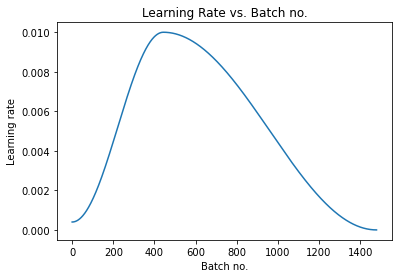

In [38]:
plot_lrs(history)

## Save to Jovian

In [39]:
!pip install jovian --upgrade

     |████████████████████████████████| 63 kB 1.1 MB/s eta 0:00:011
  Created wheel for uuid: filename=uuid-1.30-py3-none-any.whl size=6500 sha256=4986f194f22a2b1d8a9c5c624e9472d294fd982f5a43510bfa99449ce673cfc5
  Stored in directory: /root/.cache/pip/wheels/2a/ea/87/dd57f1ecb4f0752f3e1dbf958ebf8b36d920d190425bcdc24d
Successfully built uuid


In [40]:
import jovian

<IPython.core.display.Javascript object>

In [41]:
jovian.log_hyperparams(arch='resnet50', 
                       epochs=num_epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle',
                       weight_decay=weight_decay,
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Hyperparams logged.


In [42]:
print(history[-1]['train_loss'])
print(history[-1]['val_loss'])
print(history[-1]['val_acc'])

0.04976944625377655
0.06724902987480164
0.9781250357627869


In [43]:
jovian.log_metrics(train_loss=history[-1]['train_loss'],
                   val_loss=history[-1]['val_loss'],
                   val_accuracy=history[-1]['val_acc'],
                   test_accuracy=test_accuracy.item())

[jovian] Metrics logged.


In [44]:
project_name = 'week5-assignment-course-project-fcc'
jovian.commit(project=project_name, environment=None, outputs=['chest-x-ray-resnet50-model.pth'])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/babyyawlwi/week5-assignment-course-project-fcc


<IPython.core.display.Javascript object>